In [26]:
import random
from datetime import date
from collections import defaultdict
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.formula.api as smf
import pandas as pd
import scipy.stats as stats


import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # ignore the warnings

# Dataset 

In [31]:
# Read Dataset
DATA_PATH = 'dataset/'

# the zzzwasabi_songs.csv is over large, please download from https://mega.nz/file/GUhzBagS#dkWiRhRKCzTpbWtWcUvoD3Rrhleq50krvvg6n0SaI-w and put it in the dataset folder
songs = pd.read_csv(DATA_PATH + 'wasabi_songs.csv', sep='\t')  

# the wasabi_albums.csv is over large, please download from https://mega.nz/file/ScwnlarS#V59gnQY_oDOFzBplIok7nMnAC2QUq7UpbgmpDjLAWWQ and put it in the dataset folder
albums = pd.read_csv(DATA_PATH + 'wasabi_albums.csv', sep=',') 

# the wasabi_artists.csv is over large, please download from https://mega.nz/file/jUojAQjb#lV6K3U49l0xzw7XzL5zXKQscSI8hntrO_FVp8luH4zE and put it in the dataset folder
artists = pd.read_csv(DATA_PATH + 'wasabi_artists.csv', sep=',')  

# # https://mega.nz/file/CUpl0KKJ#tLlL1eMKjX94ZJvpaO7w7HFtozpKDlyruVwRt2z-9G4
# topics = pd.read_pickle(DATA_PATH + 'song_id_to_topics/song_id_to_topics.pickle') 

# emotion labels derived from a different method, might be useful.
# emotion_tags = pd.read_pickle(DATA_PATH + 'lastfm_id_to_emotion_tags.pickle')

In [33]:
# Overview of the dataset
print("============Songs============")
languages = songs.groupby('language_detect') # there are two language attributes (language, language_detect) here I choose the detected one to get more labelled instances.
print("|| [attributes of the dataset]: ", list(songs))
print("|| [number of songs]: ", len(songs))
print("|| [number of songs that have the language label]: ", songs['language_detect'].isna().sum())
print("|| [languages]: ", languages.groups.keys())

print("\n============Albums============")
print("|| [attributes of the album dataset]: ", list(albums))


print("\n============Artists============")
print("|| [attributes of the dataset]: ", list(artists))
print("|| [number of artists that do not have country info]: ", artists['location.country'].isna().sum())

============Songs============
|| [attributes of the dataset]:  ['Unnamed: 0', '_id', 'abstract', 'albumTitle', 'album_genre', 'animux_content', 'animux_contents', 'animux_path', 'animux_paths', 'arousal', 'arousal_predicted', 'artist', 'artist_lower', 'availableCountries', 'award', 'begin', 'bpm', 'chords_metadata', 'deezer_mapping', 'disambiguation', 'end', 'explicit_content_lyrics', 'explicit_content_lyrics_predicted', 'format', 'gain', 'genre', 'has_emotion_tags', 'has_social_tags', 'id_album', 'id_album_deezer', 'id_artist_deezer', 'id_song_deezer', 'id_song_musicbrainz', 'isClassic', 'isrc', 'langdetect_robust', 'language', 'language_detect', 'lastfm_id', 'length', 'lengthAlbum', 'multitrack_file', 'multitrack_path', 'newPreview', 'notes', 'origin', 'position', 'preview', 'producer', 'publicationDate', 'publicationDateAlbum', 'rank', 'rdf', 'recordLabel', 'recorded', 'releaseDate', 'runtime', 'subject', 'title', 'title_accent_fold', 'title_lower', 'urlAllmusic', 'urlAmazon', 'urlD

In [34]:
# extract the album publication year from the album dataset and merge that with the songs dataset.
albums_select = albums.rename(columns={'_id': 'id_album', 'publicationDate': 'album_pub_year'})
artists_select = artists.rename(columns={'_id': 'id_artist'})

lyric_data = pd.merge(songs, albums_select, on=['id_album'], how='left') 
lyric_data = pd.merge(lyric_data, artists_select, on=['id_artist'], how='left') 

# remove songs with missing or inconsistent non-numeric year labels.
lyric_data_cleaned = lyric_data.copy()
lyric_data_cleaned['album_pub_year'] = pd.to_datetime(lyric_data_cleaned['album_pub_year'], errors='coerce') # unify the date format to datetime
lyric_data_cleaned = lyric_data_cleaned[pd.to_numeric(lyric_data_cleaned['album_pub_year'], errors='coerce').notnull()] # convert dates in incorrect formats to null
lyric_data_cleaned = lyric_data_cleaned[pd.notnull(lyric_data_cleaned['album_pub_year'])] # remove all songs with incorrect formats of dates
lyric_data_cleaned['album_pub_year'] = pd.DatetimeIndex(lyric_data_cleaned['album_pub_year']).year # only keep the year part
lyric_data_cleaned = lyric_data_cleaned[(lyric_data_cleaned['album_pub_year'] >= 1960)] # only consider the songs after 1960 to avoid outliers, as songs recored earlier are very sparse.

# EDA

## emotion distribution across languages

In [35]:
# filter
def filtering (data, threshold, by):
    grouped_data = data.groupby(by)[by].count()
    remain = list()
    groups = grouped_data.index
    for gp in groups:
        if grouped_data[gp] >= threshold:
            remain.append(gp)
    data_remain = data[data[by].isin(remain)]
    return data_remain

In [36]:
# visualise the distribution of emotions measured in valence and arousal for all languages that have more than [threshold] songs
# groupby language: 'language_detect' or country: 'country'
# return a dataframe that record average valence and arousal for each language.
def emotion_distribution (lyric_data, group_by, threshold, title):
    
    lyric_data_major = filtering (lyric_data, threshold, group_by)
    
    valence_predicted_mean = lyric_data_major.groupby(group_by)['valence_predicted'].mean()
    arousal_predicted_mean = lyric_data_major.groupby(group_by)['arousal_predicted'].mean()
#     groups = lyric_data_major.groupby(group_by).groups.keys()
    
    emotions_mean = pd.concat([valence_predicted_mean, arousal_predicted_mean], axis=1)
    
#     print(emotions_mean)
    plt.figure(figsize=(16,8))        
    sns.scatterplot(data=emotions_mean, x="valence_predicted", y="arousal_predicted", hue=group_by)
    plt.title(title)
    for i in range(emotions_mean.shape[0]):
         plt.text(x=emotions_mean.valence_predicted[i]+0.003,y=emotions_mean.arousal_predicted[i]+0.003,s=emotions_mean.index[i], 
                  fontdict=dict(color='red',size=10),
                  bbox=dict(facecolor='yellow',alpha=0.5))
            
    plt.legend(title=group_by, loc='upper left', bbox_to_anchor=(1, 1), ncol=3)
    plt.axhline(linewidth=1, color="grey")
    plt.axvline(linewidth=1, color="grey")
    plt.show()
    return emotions_mean

 all of languages without filtering

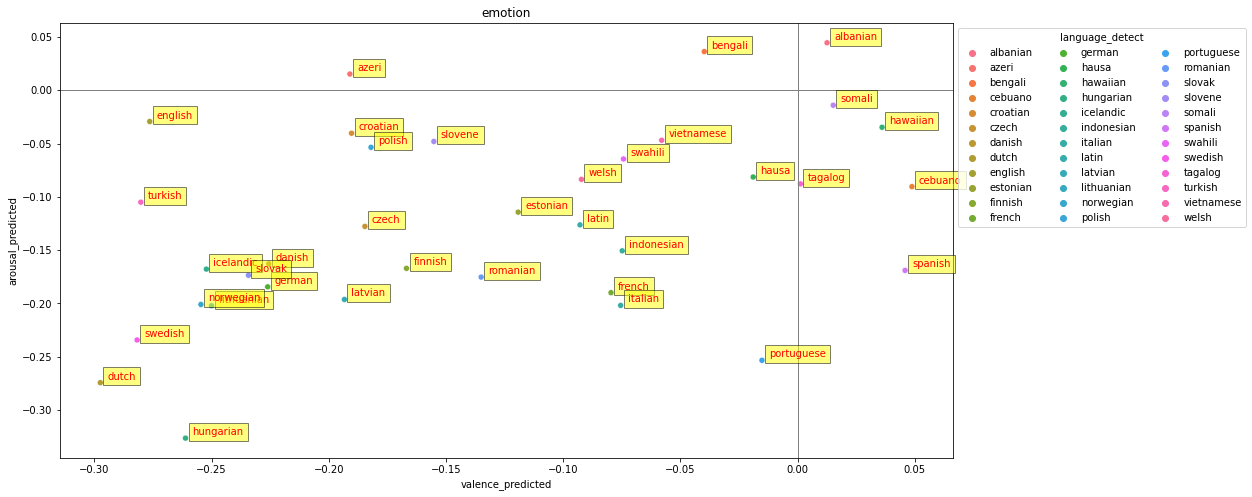

In [37]:
emotion_full = emotion_distribution(lyric_data_cleaned, 'language_detect', 0, 'emotion')

only leaves english and spanish (have more than 100000 songs) --- this seems interesting that english songs are generally much more negative than spanish.

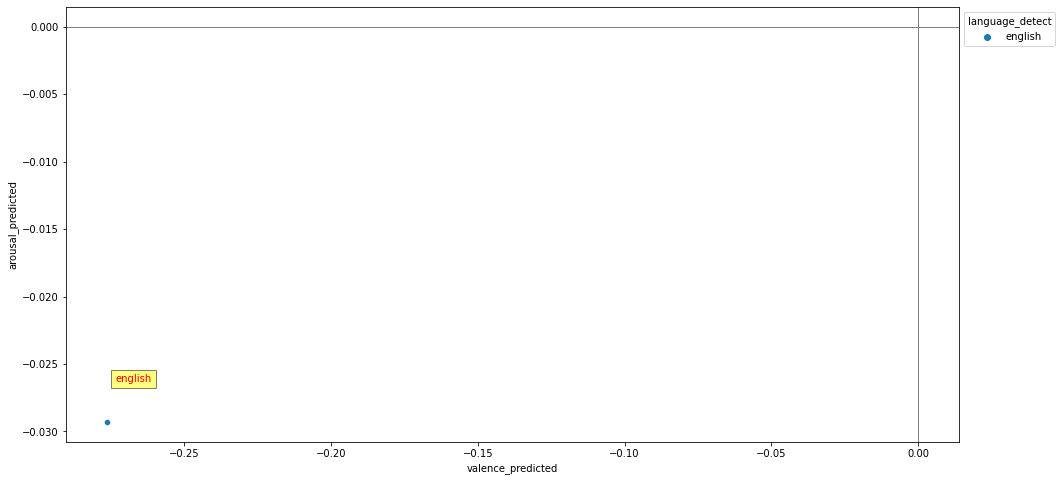

In [9]:
# THRESHOLD = 1000
THRESHOLD = 100000 

emotion_100000 = emotion_distribution(lyric_data_cleaned, 'language_detect', THRESHOLD)

most languages show both negative valence and arousal, but with the exceptions:

In [38]:
positive_valence = emotion_full[emotion_full['valence_predicted'] > 0]
positive_arousal = emotion_full[emotion_full['arousal_predicted'] > 0]

print("languages that generally show positivity: ", list(positive_valence.index))
print("languages that generally show high intensity: ", list(positive_arousal.index))

languages that generally show positivity:  ['albanian', 'cebuano', 'hawaiian', 'somali', 'spanish', 'tagalog']
languages that generally show high intensity:  ['albanian', 'azeri', 'bengali']


## emotion distribution for each language

In [39]:
for language, gp in lyric_data_cleaned.groupby('language_detect'):
    gp.plot.scatter(x='valence_predicted', y='arousal_predicted', alpha = 0.1)
    plt.title(language)
    plt.axhline(linewidth=1, color="grey")
    plt.axvline(linewidth=1, color="grey")

KeyboardInterrupt: 

## emotion change across time for each language

there are some errors in the publication date label for each individual song. e.g. 0000-00-00, 2100-01-01, probably due to the scraping errors, so we use the album publication date as proxy

In [12]:
### emotion changes over time for each language.
# the time for each song is approximated by the album publcation year.
# the red line is a regression line fitted to the data, the shaded area is the error margin.
# the number in the title is the slope coefficient of the regression line

# return the regression coefficient for each language.
def emotion_over_time (data, dimension):
    overall_trend = defaultdict()
    
    emotion_mean_time = data.groupby(['language_detect', 'album_pub_year'])[dimension].mean().reset_index()
    grouped = emotion_mean_time.groupby('language_detect')
    
    ncols = 2
    nrows = int(np.ceil(grouped.ngroups / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,60), sharey=True)
    fig.tight_layout(pad=5.0)

    for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
        language_group = grouped.get_group(key)

        # regression line statistics
        slope, intercept, r_value, p_value, std_err = stats.linregress(language_group['album_pub_year'], language_group[dimension])
        overall_trend[key] = slope
        
        sns.regplot(
            data = language_group,
            x = 'album_pub_year',
            y = dimension,
            line_kws={"color": "red"},
            ax = ax
        )
        
        ax.axhline(linewidth=1, color="grey")
        ax.set_title(key + ": " + str(round(slope, 5)))
        ax.set_xlabel('publication year')
        
    plt.xlim(left = 1960)  # majority of songs in the dataset are released after 1960 
    plt.show()
    return overall_trend

valence over time

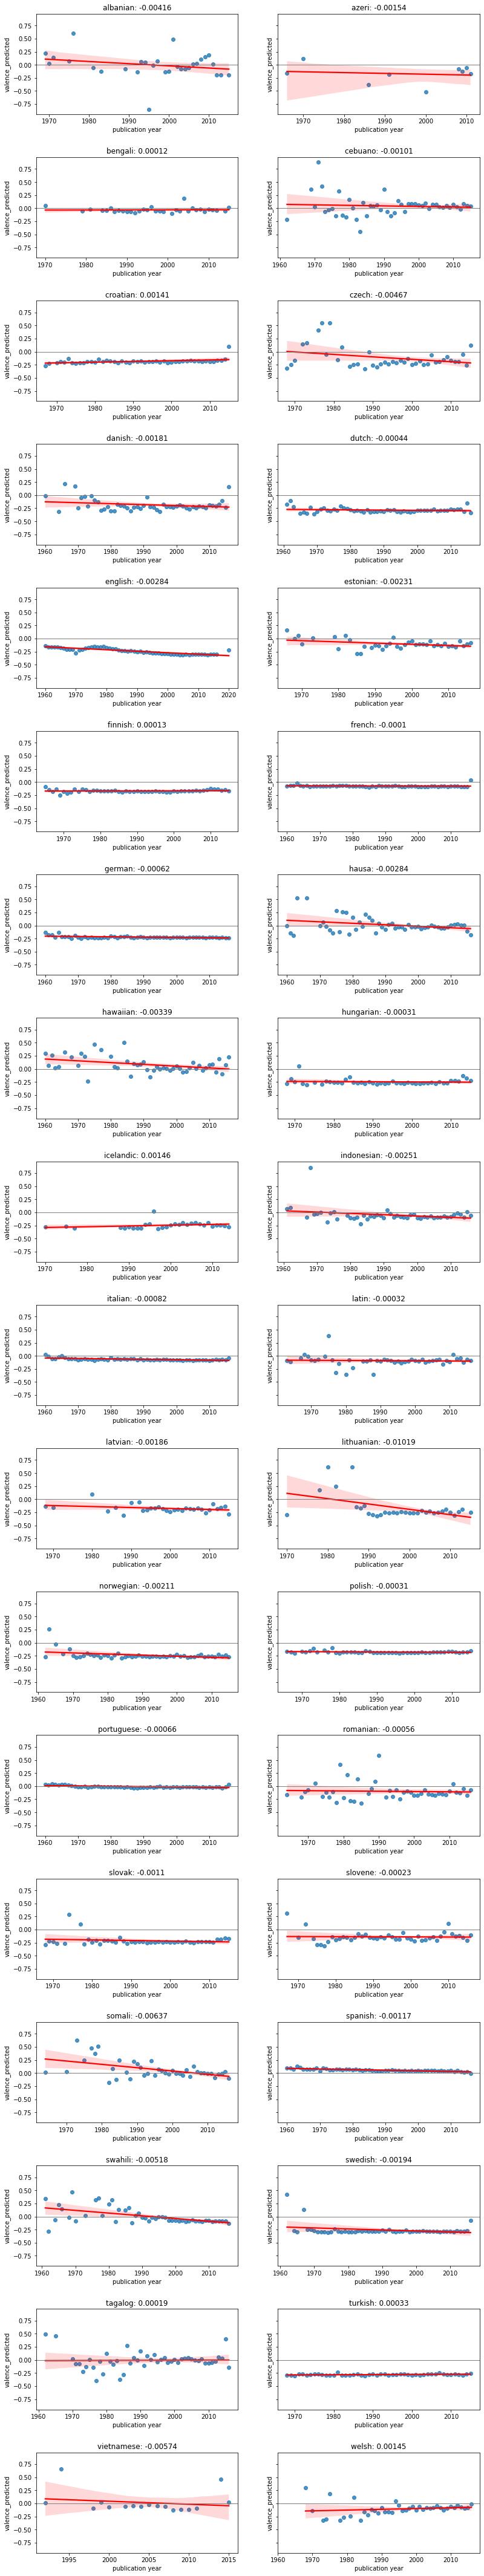

In [13]:
valence_trend = emotion_over_time(lyric_data_cleaned, 'valence_predicted')

arousal over time

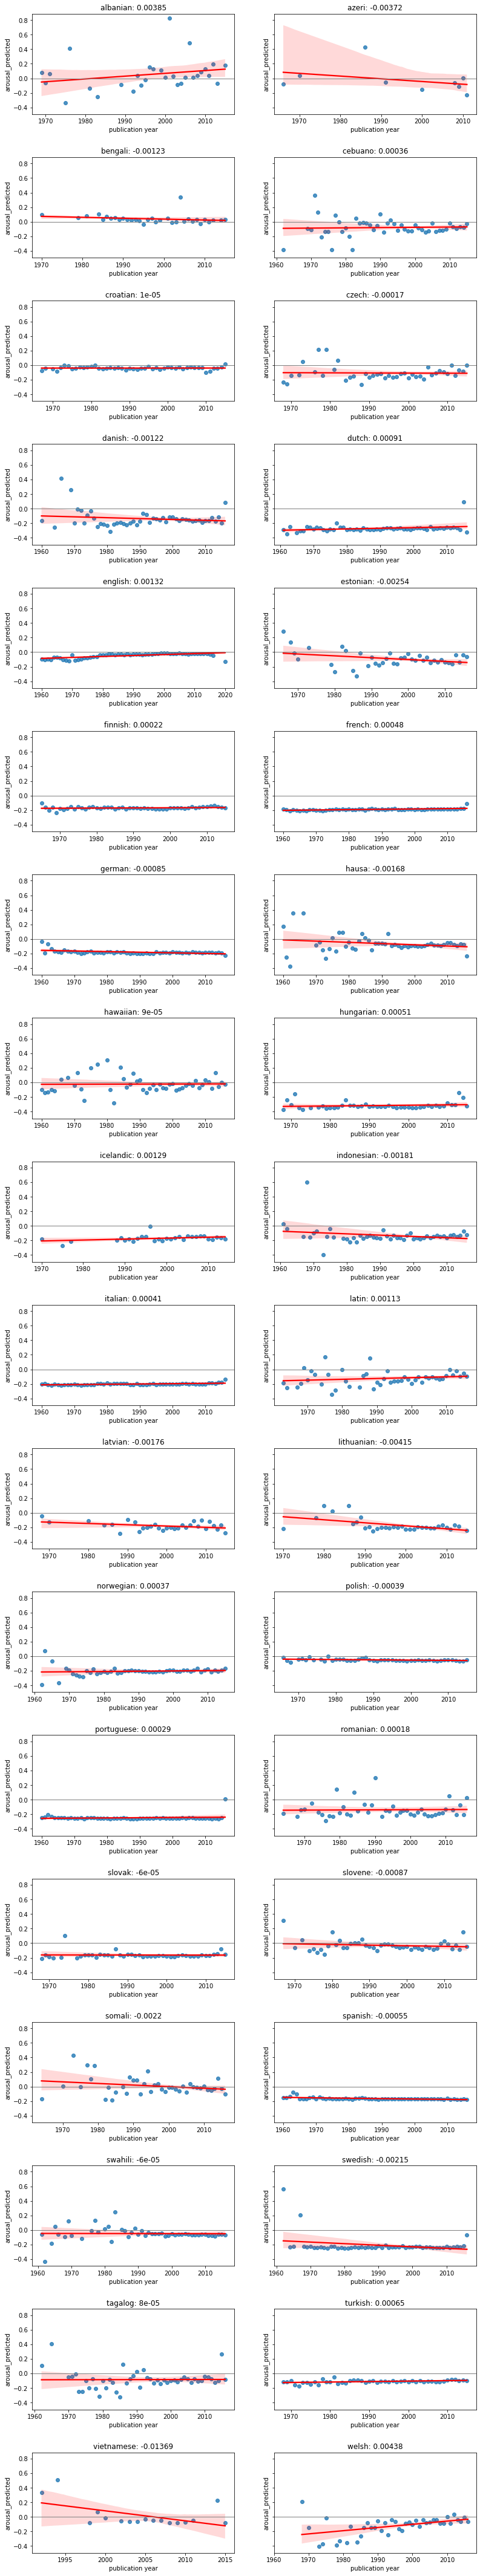

In [14]:
arousal_trend = emotion_over_time(lyric_data_cleaned, 'arousal_predicted')

## overview on all languages

### mean

Text(0, 0.5, 'average valence')

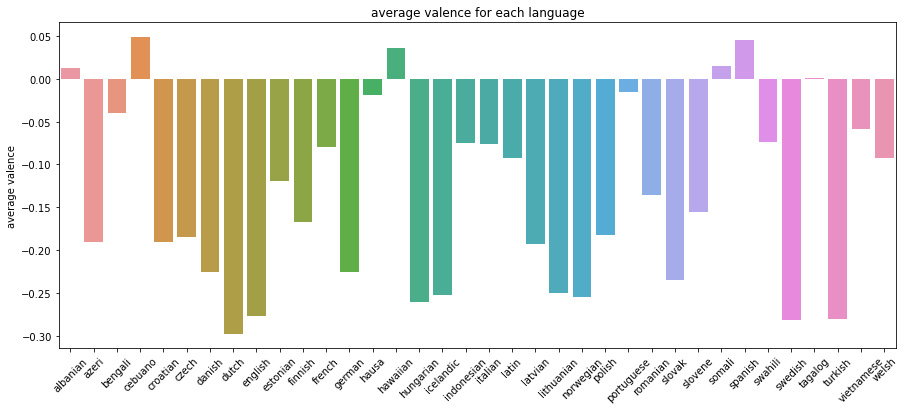

In [15]:
# Can filter out the languages that have less than a number of songs by specifying the THRESHOLD
# eg.
# THRESHOLD = 1000
# emotion_1000 = emotion_distribution(song_language_dist, THRESHOLD)

# currently using:
# emotion_full = emotion_distribution(song_language_dist, 0)


plt.figure(figsize=(15,6))
sns.barplot(x=list(emotion_full.index), y=list(emotion_full['valence_predicted']))
plt.xticks(rotation = 45) 
plt.title("average valence for each language")
plt.ylabel("average valence")

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(x=list(emotion_full.index), y=list(emotion_full['arousal_predicted']))
plt.xticks(rotation = 45) 
plt.title("average arousal for each language")
plt.ylabel("average arousal")

### trend

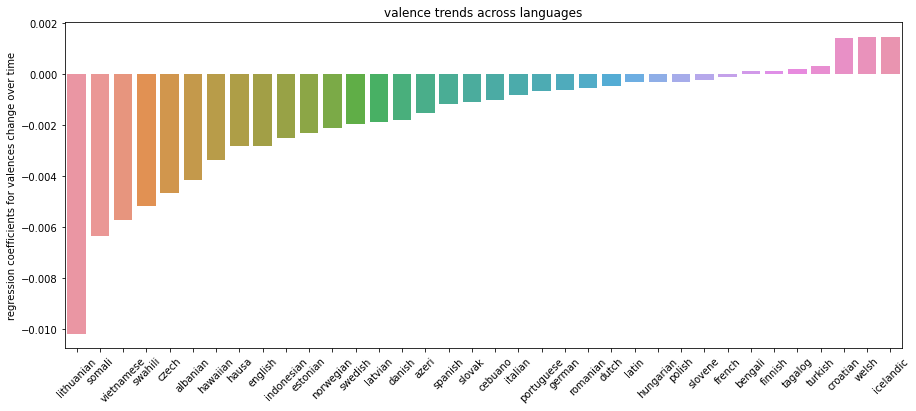

In [16]:
# overview the regression coefficients indicating the trends in the valence change over time for each language.
valence_trend_sorted = dict(sorted(valence_trend.items(), key=lambda x:x[1]))
plt.figure(figsize=(15,6))
sns.barplot(x=list(valence_trend_sorted.keys()), y=list(valence_trend_sorted.values()))
plt.xticks(rotation = 45) 
plt.title("valence trends across languages")
plt.ylabel("regression coefficients for valences change over time")
plt.show()

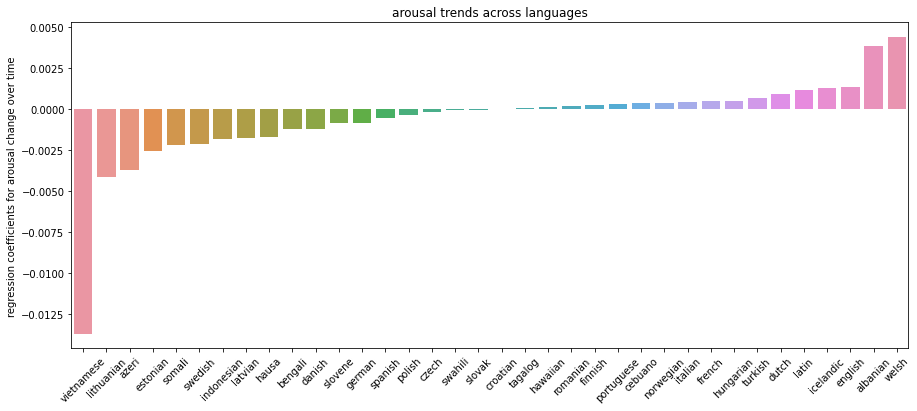

In [17]:
# overview the regression coefficients indicating the trends in the arousal change over time for each language.
arousal_trend_sorted = dict(sorted(arousal_trend.items(), key=lambda x:x[1]))
plt.figure(figsize=(15,6))
sns.barplot(x=list(arousal_trend_sorted.keys()), y=list(arousal_trend_sorted.values()))
plt.xticks(rotation = 45) 
plt.title("arousal trends across languages")
plt.ylabel("regression coefficients for arousal change over time")
plt.show()

## English and Spanish 

### average emotions
English vs English originated from Spanish \
Spanish vs Spanish originated from English

In [41]:
lyric_english = lyric_data_cleaned[lyric_data_cleaned['language_detect'] == 'english']
lyric_spanish = lyric_data_cleaned[lyric_data_cleaned['language_detect'] == 'spanish']

In [19]:
# lyric_language_origin
# top 3 country that mainly speaks Spanish: Maxico-MX, Spanish-ES, Argentina-AR
# top 3 country that mainly speaks English: United States-US, Canada-CA, Australia-AU (there is no UK)
lyric_english_spain = lyric_english[lyric_english['country'].isin(['ES', 'MX', 'AR', 'US', 'AU', 'CA'])]
lyric_spain_english = lyric_spanish[lyric_spanish['country'].isin(['ES', 'MX', 'AR', 'US', 'AU', 'CA'])]

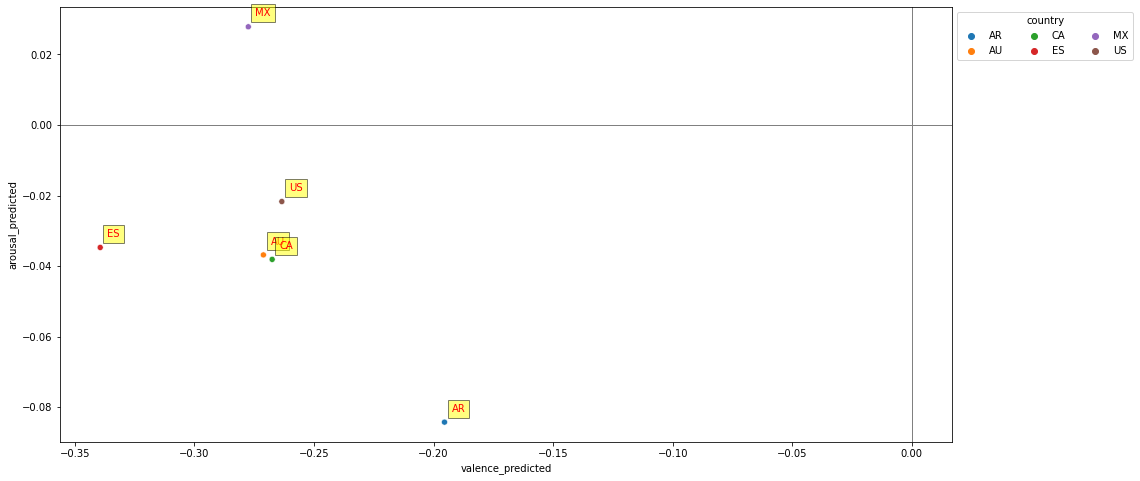

valence_predicted  arousal_predicted
country                                      
AR               -0.195424          -0.084203
AU               -0.271150          -0.036815
CA               -0.267492          -0.038088
ES               -0.339405          -0.034706
MX               -0.277458           0.027833
US               -0.263447          -0.021688

In [20]:
emotion_distribution(lyric_english_spain, 'country', 0)

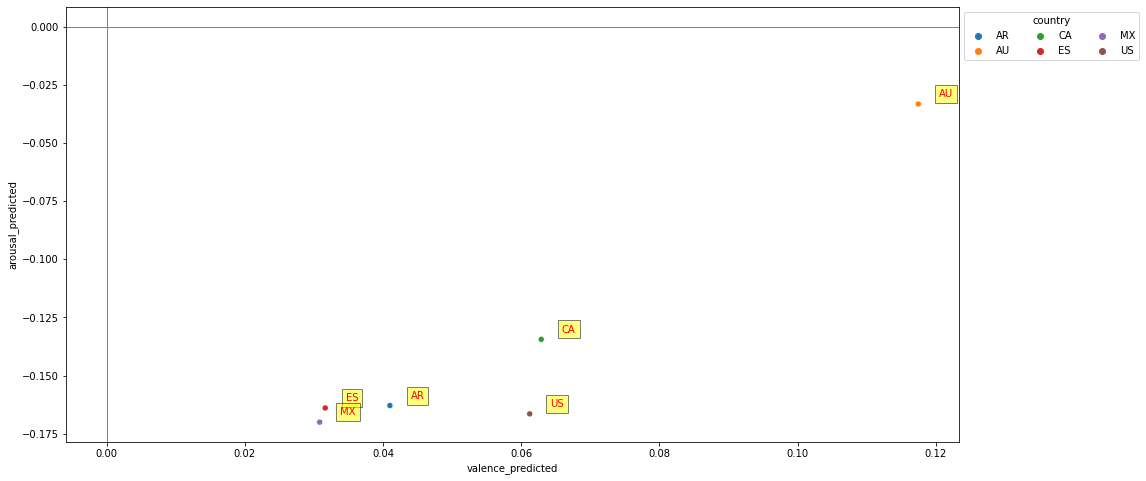

valence_predicted  arousal_predicted
country                                      
AR                0.040990          -0.162895
AU                0.117468          -0.033213
CA                0.062890          -0.134442
ES                0.031629          -0.163953
MX                0.030824          -0.170043
US                0.061224          -0.166499

In [21]:
emotion_distribution(lyric_spain_english, 'country', 0)

## country based analysis

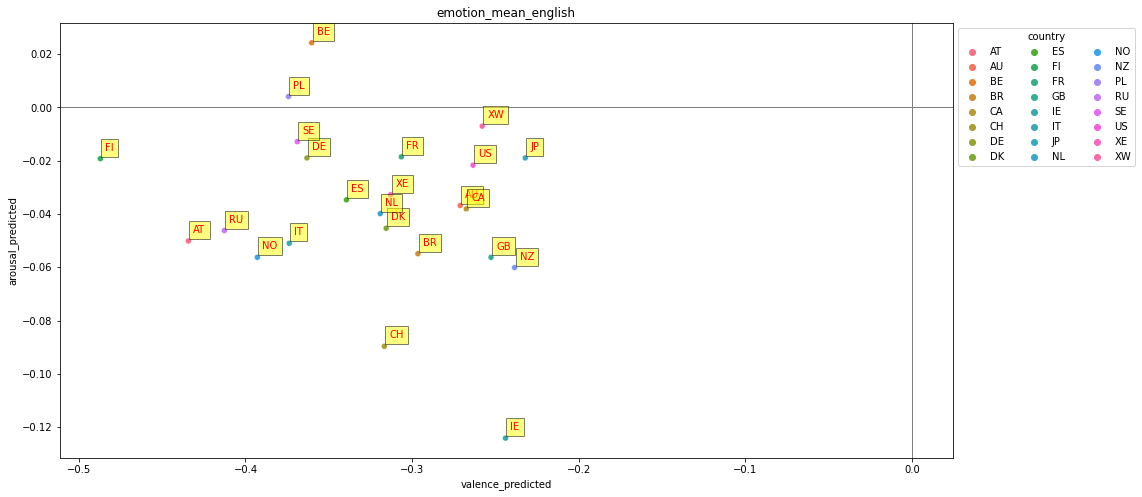

In [45]:
emotion_mean_english = emotion_distribution(lyric_english, 'country', 500, 'emotion_mean_english')

### distribution of emotion values for each country

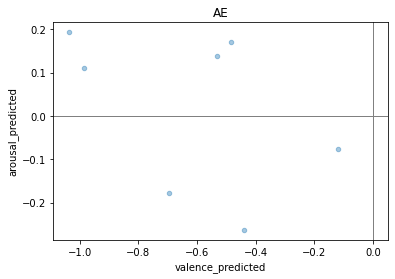

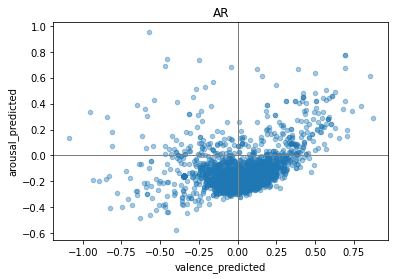

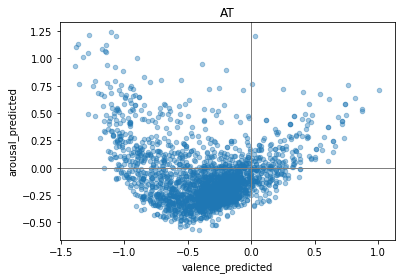

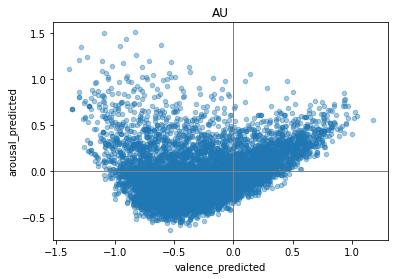

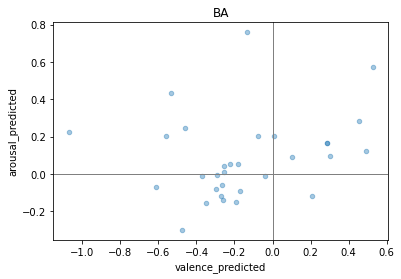

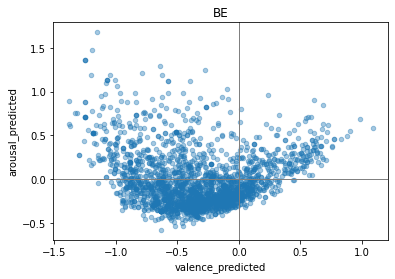

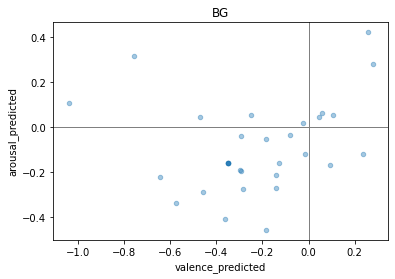

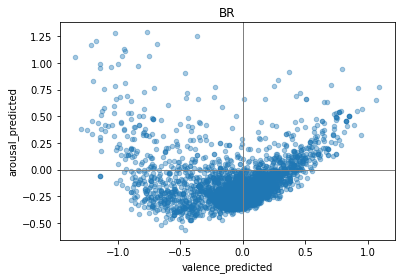

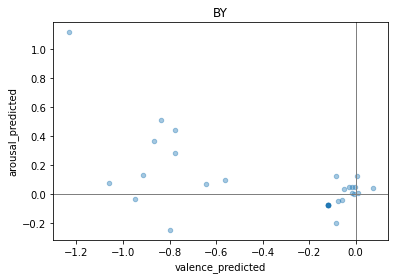

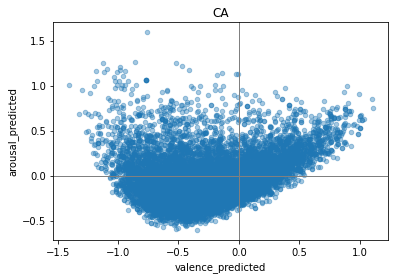

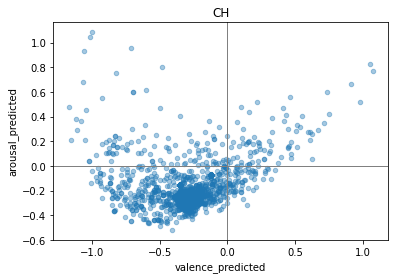

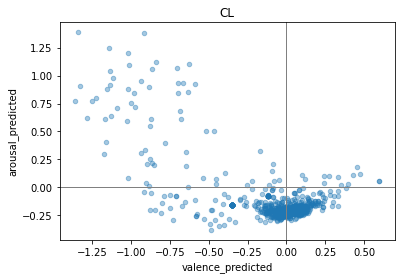

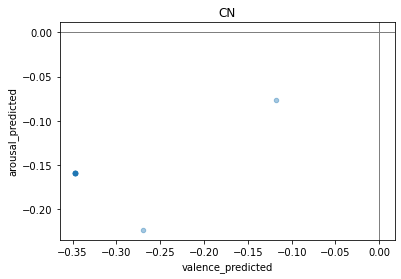

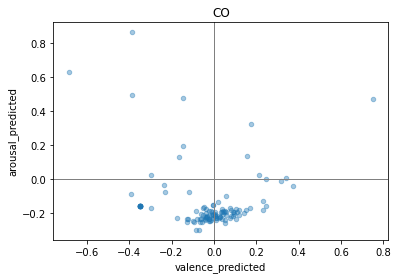

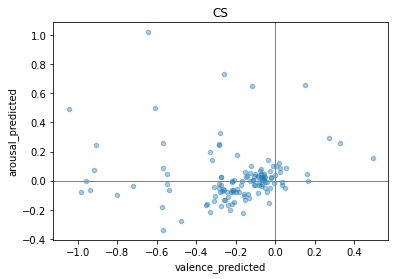

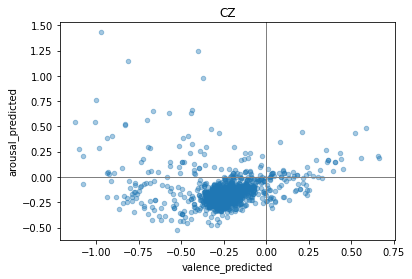

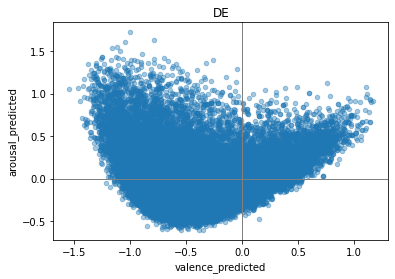

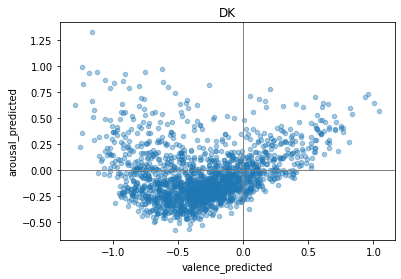

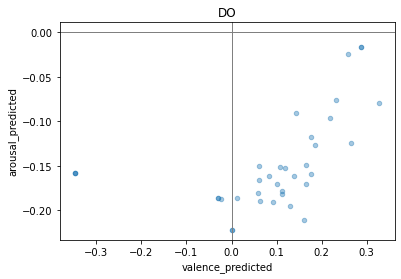

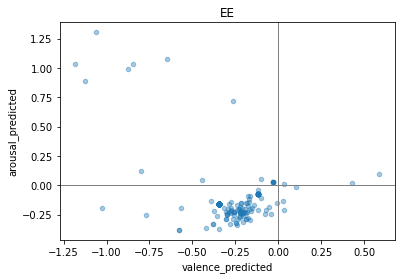

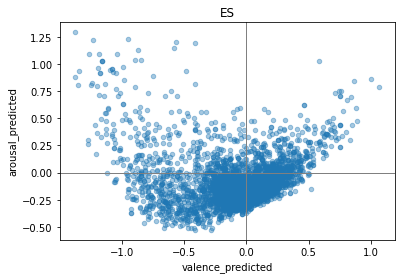

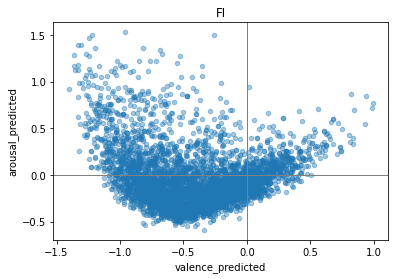

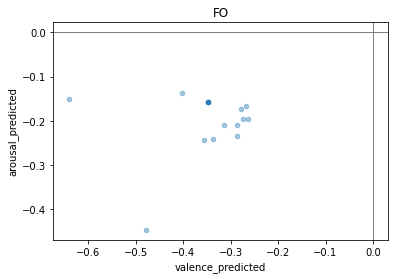

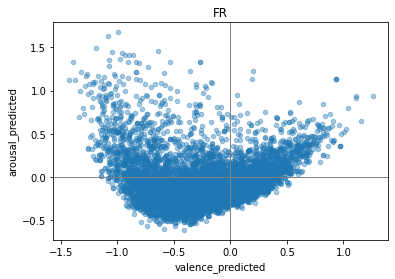

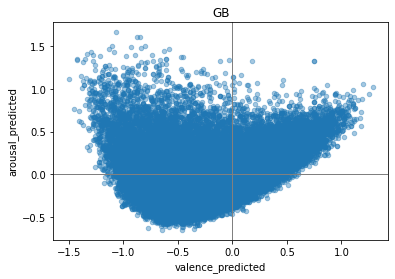

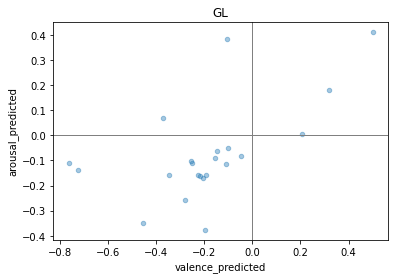

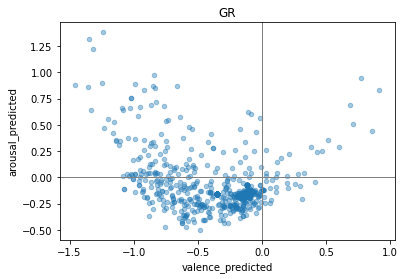

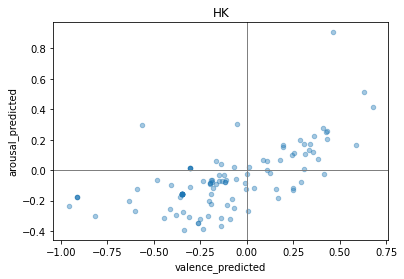

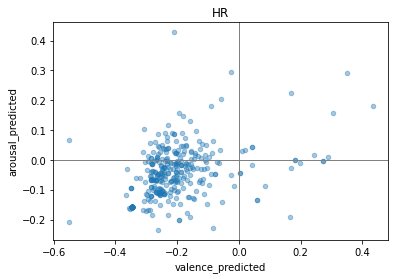

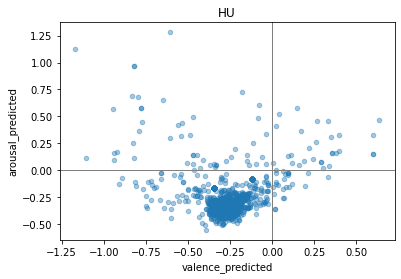

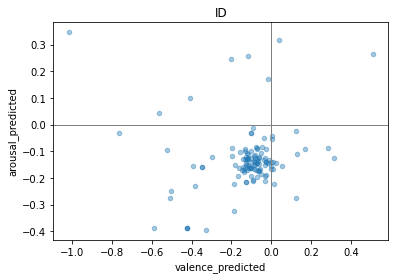

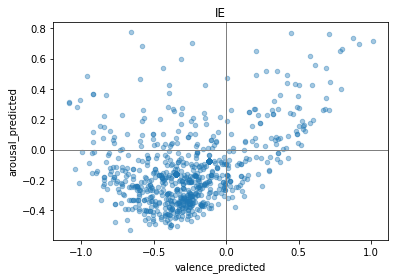

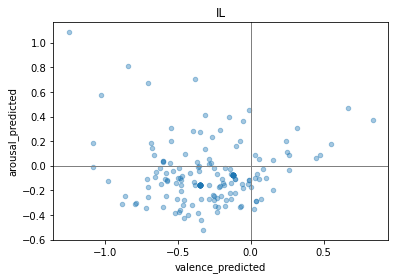

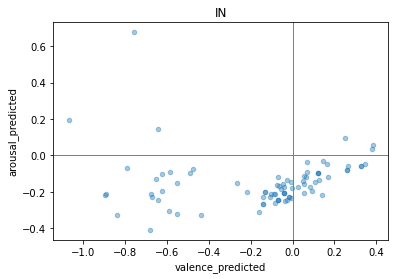

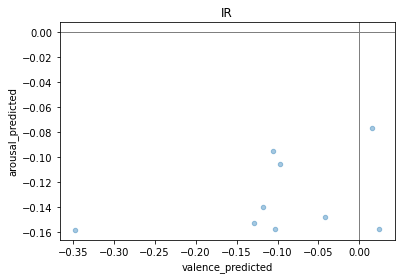

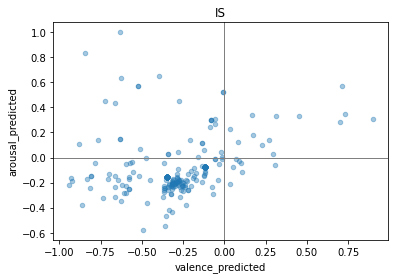

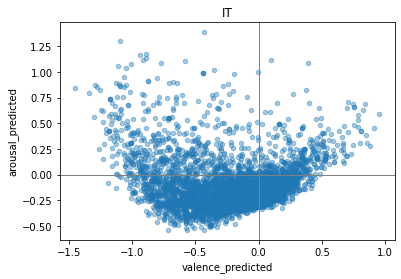

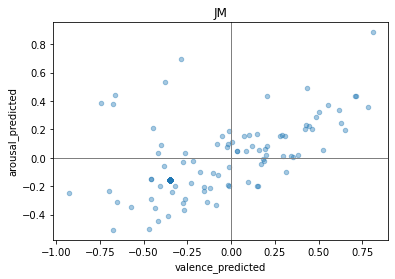

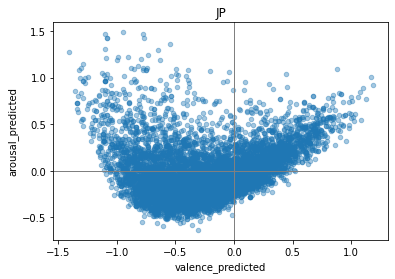

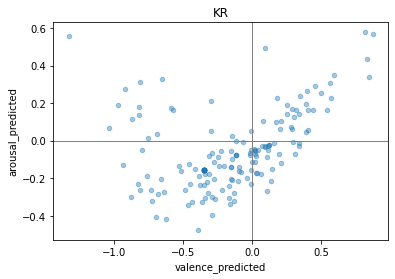

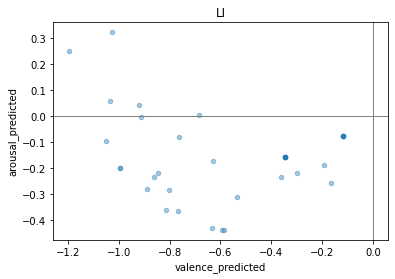

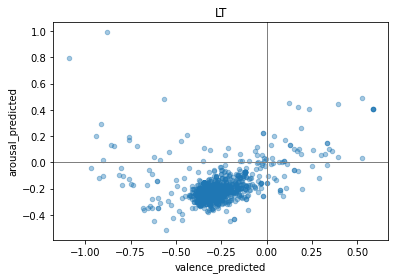

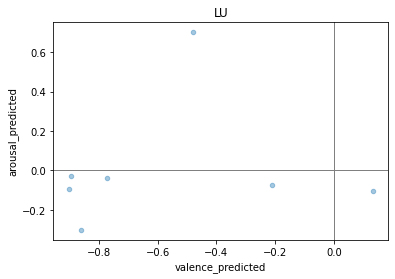

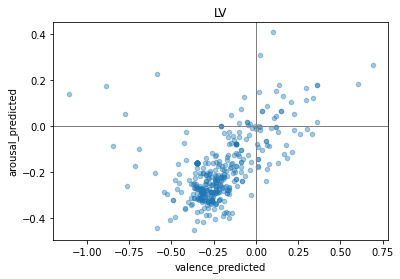

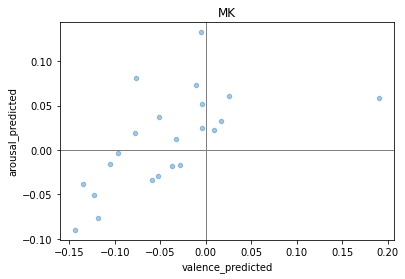

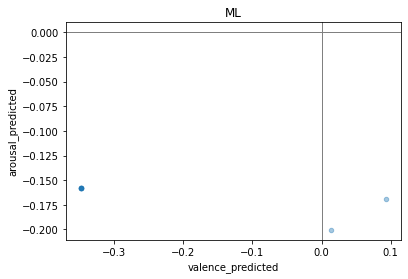

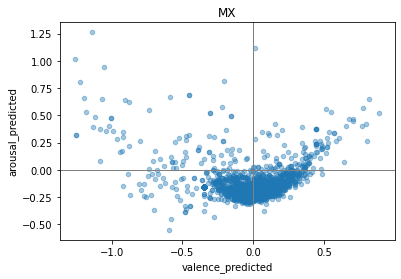

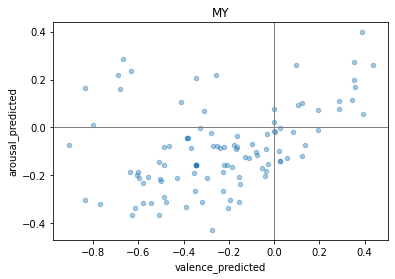

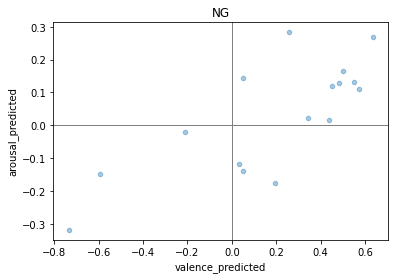

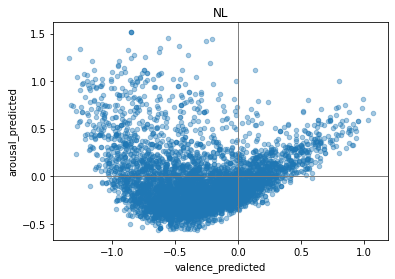

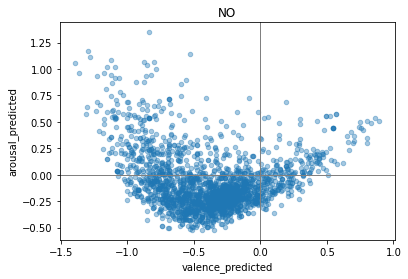

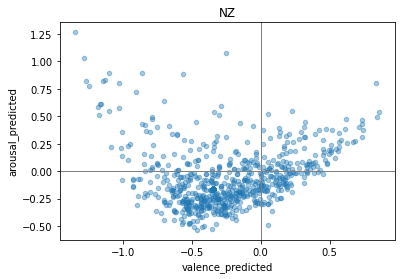

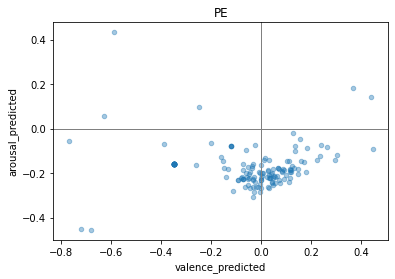

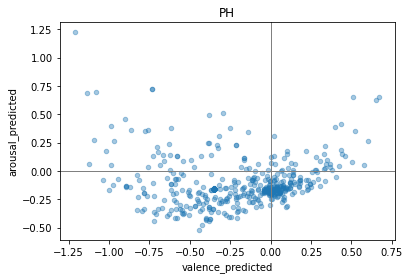

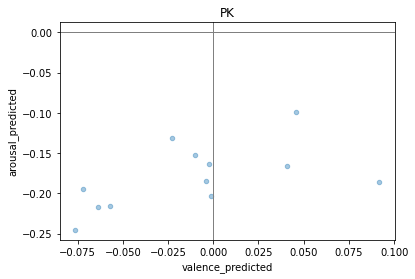

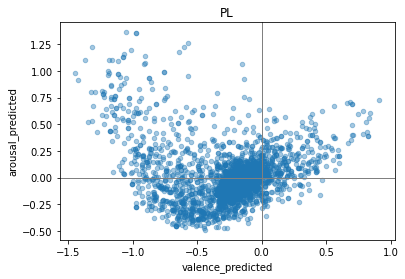

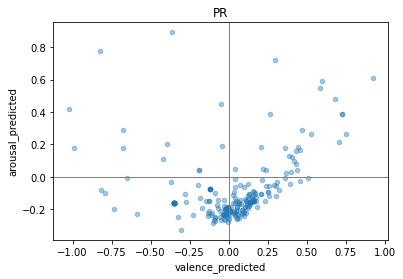

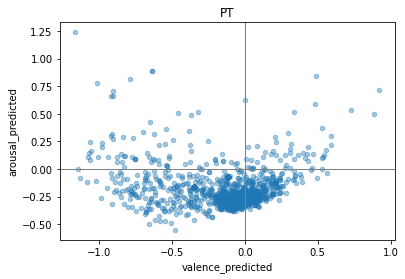

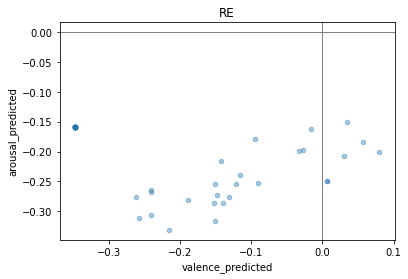

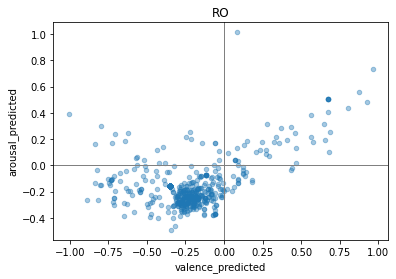

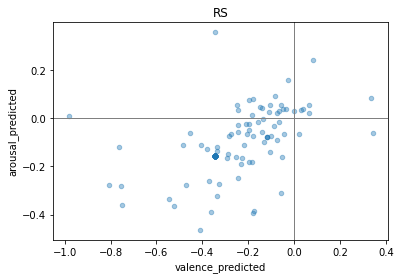

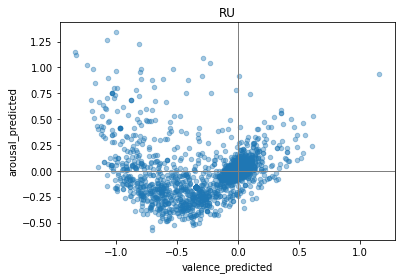

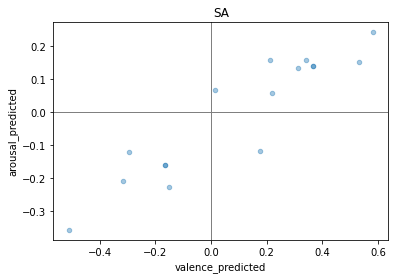

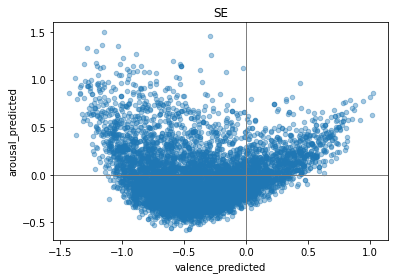

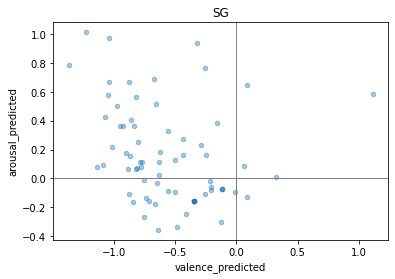

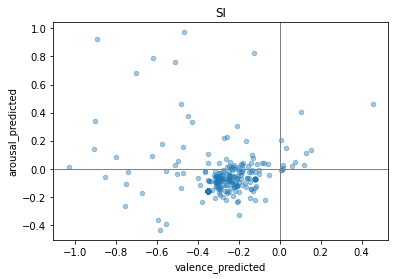

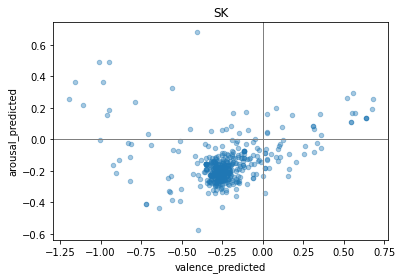

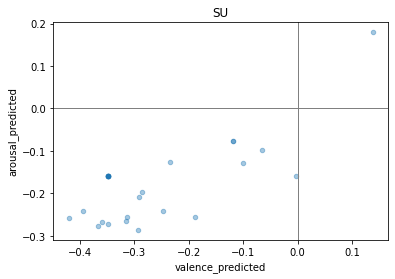

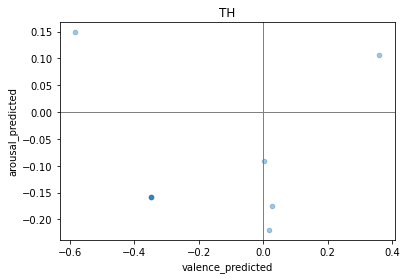

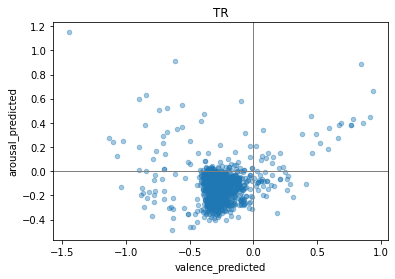

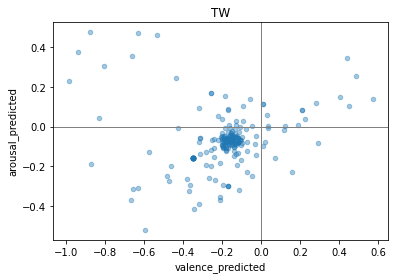

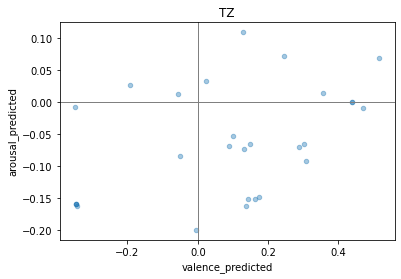

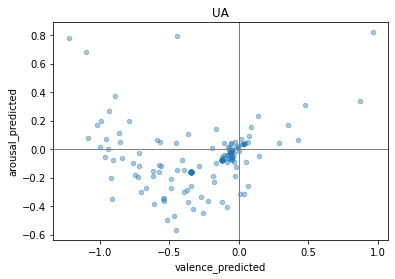

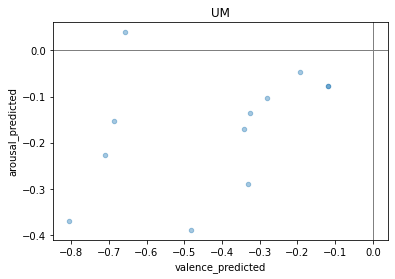

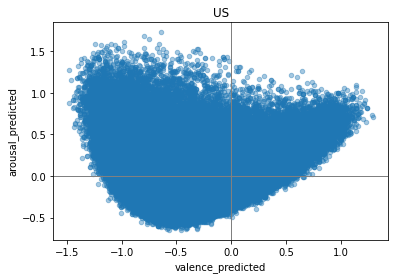

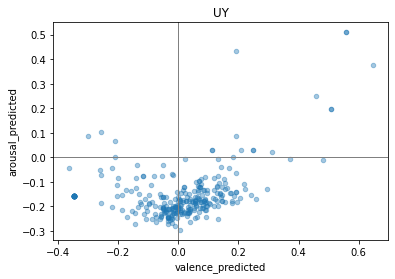

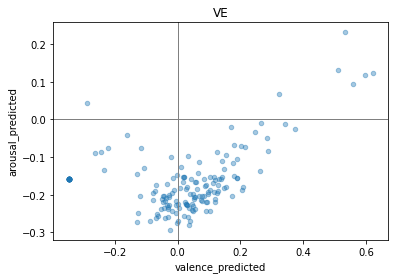

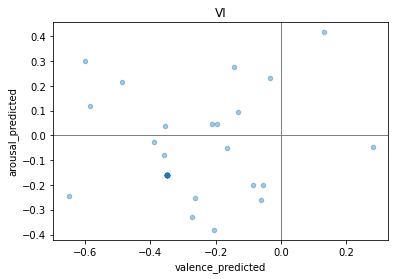

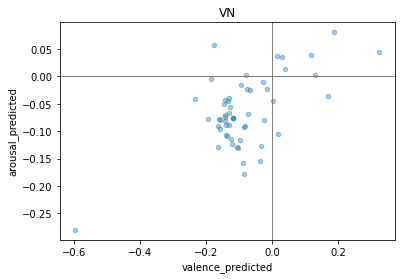

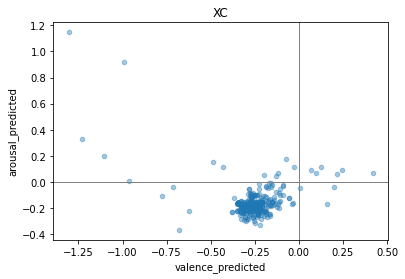

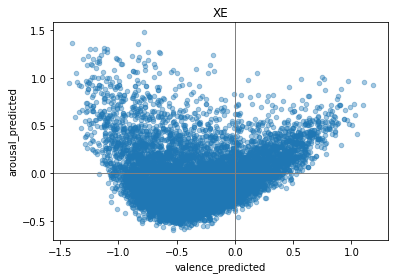

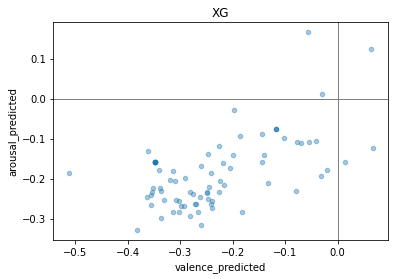

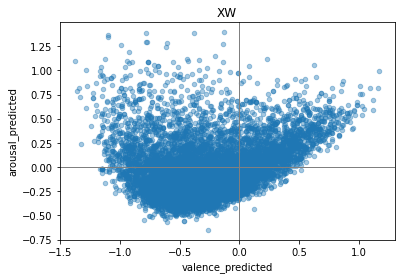

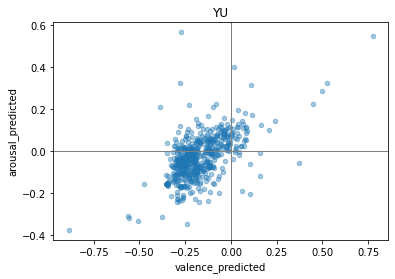

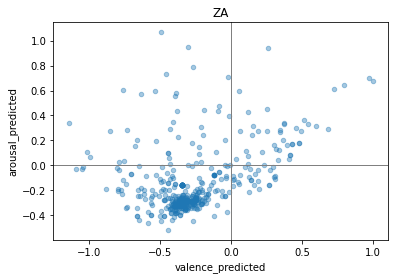

In [24]:
for country, gp in lyric_data_cleaned.groupby('country'):
    gp.plot.scatter(x='valence_predicted', y='arousal_predicted', alpha = 0.4)
    plt.title(country)
    plt.axhline(linewidth=1, color="grey")
    plt.axvline(linewidth=1, color="grey")

### distribution of the genre

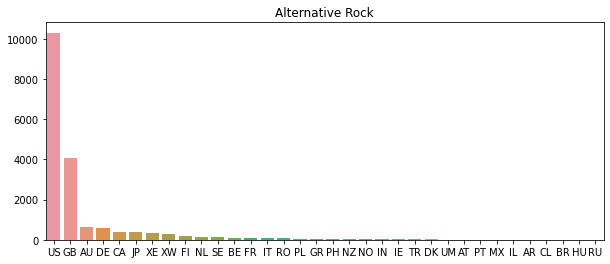

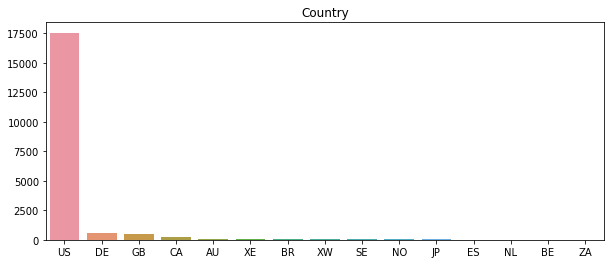

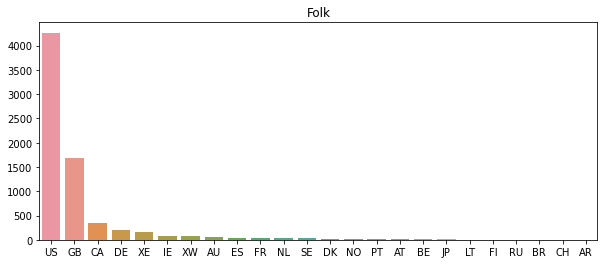

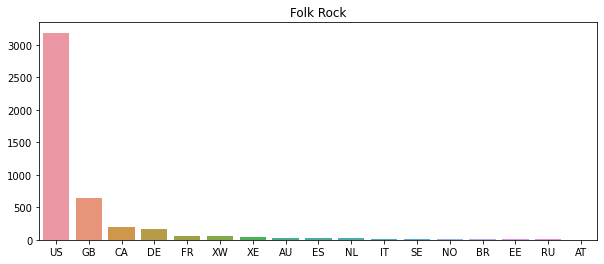

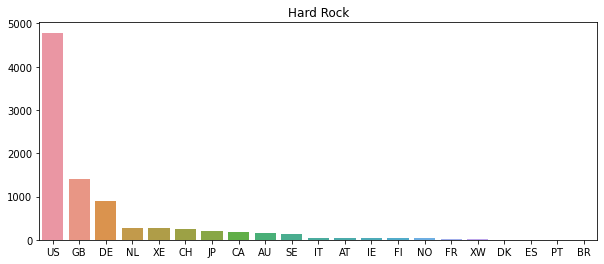

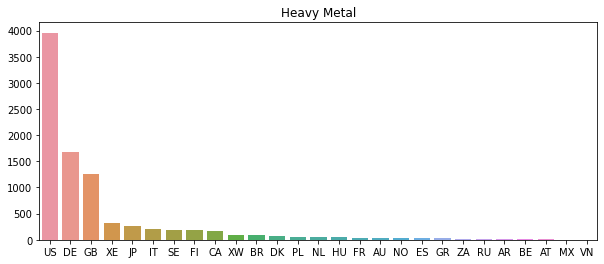

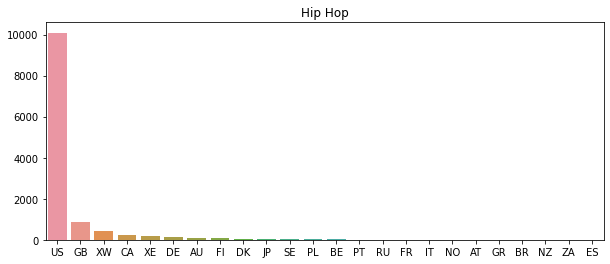

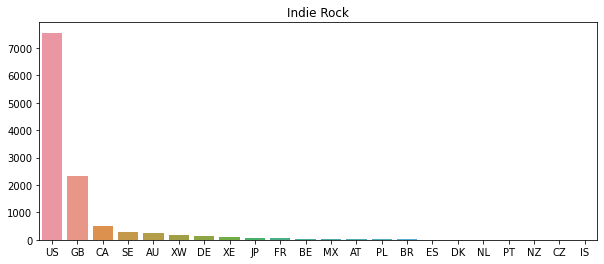

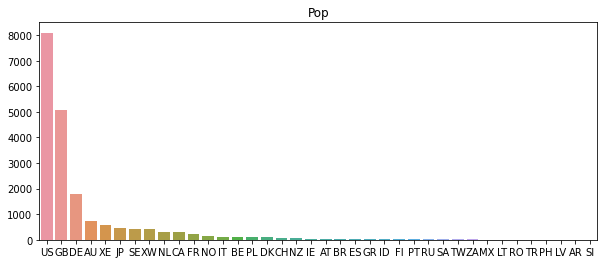

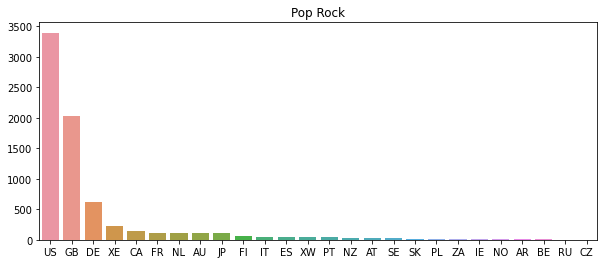

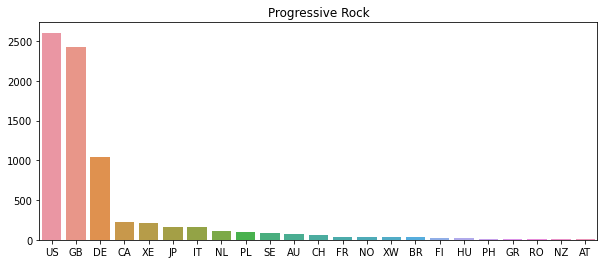

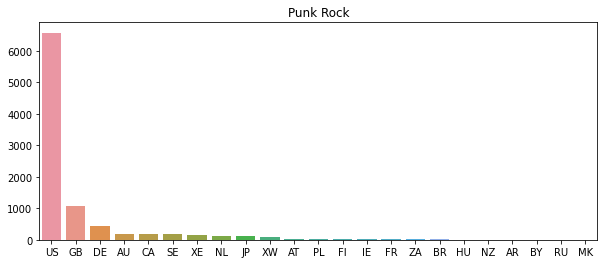

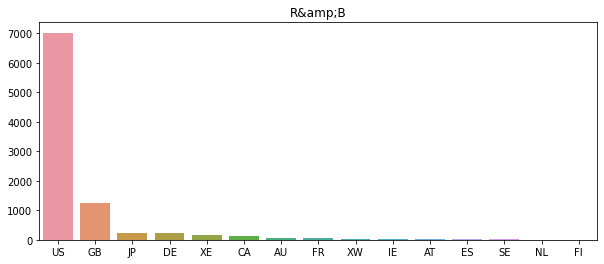

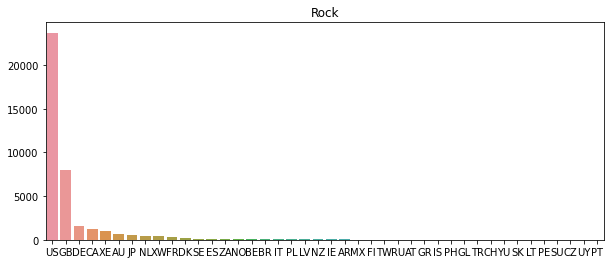

In [40]:
genre_dist = defaultdict()
for genre, gp in lyric_english.groupby('album_genre'):
    if len(gp.index) > 10000:
        plt.figure(figsize=(10,4)) 
        countries = gp['country'].value_counts().index
        count = gp['country'].value_counts().values
        sns.barplot(x=countries, y=count)
        plt.title(genre)

### distribution of emotion values for each genre

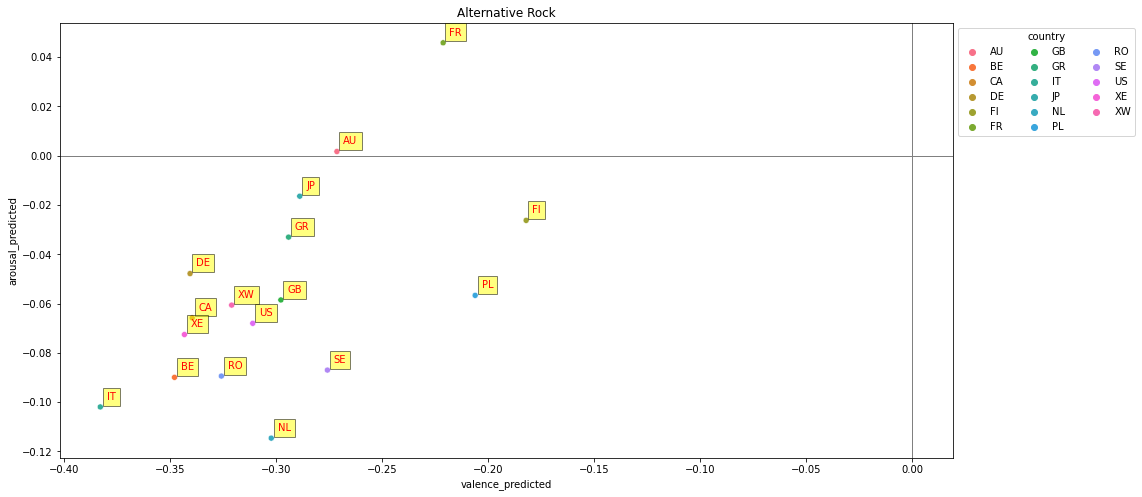

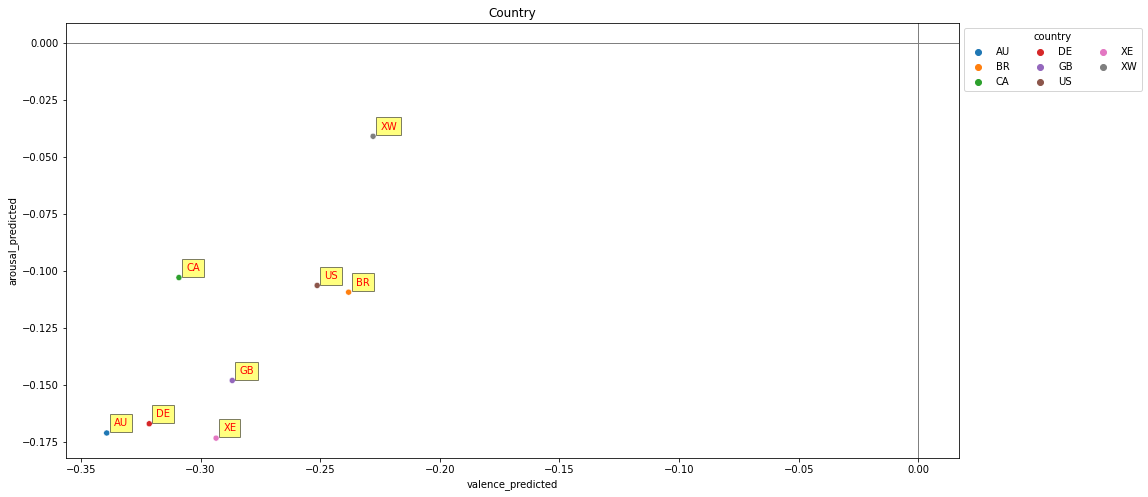

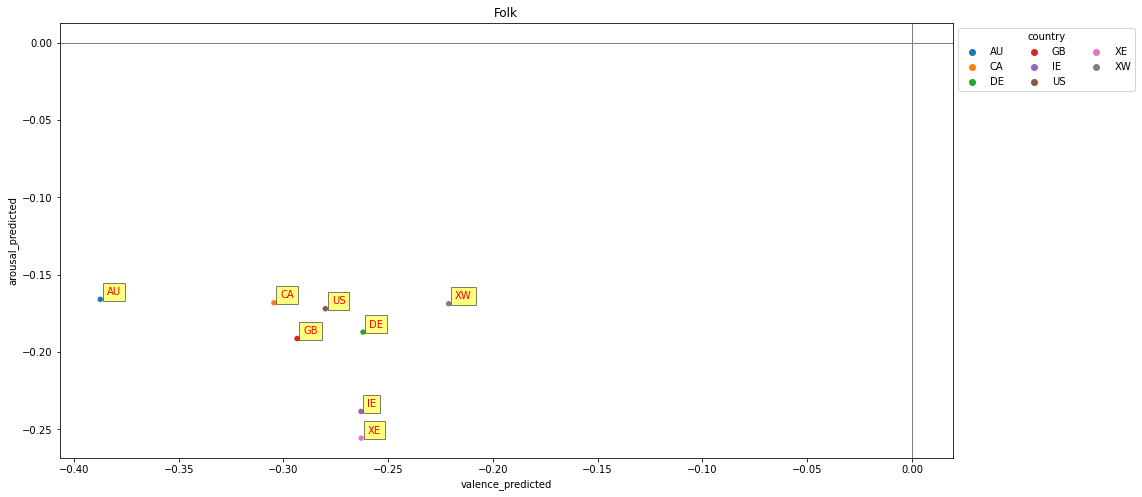

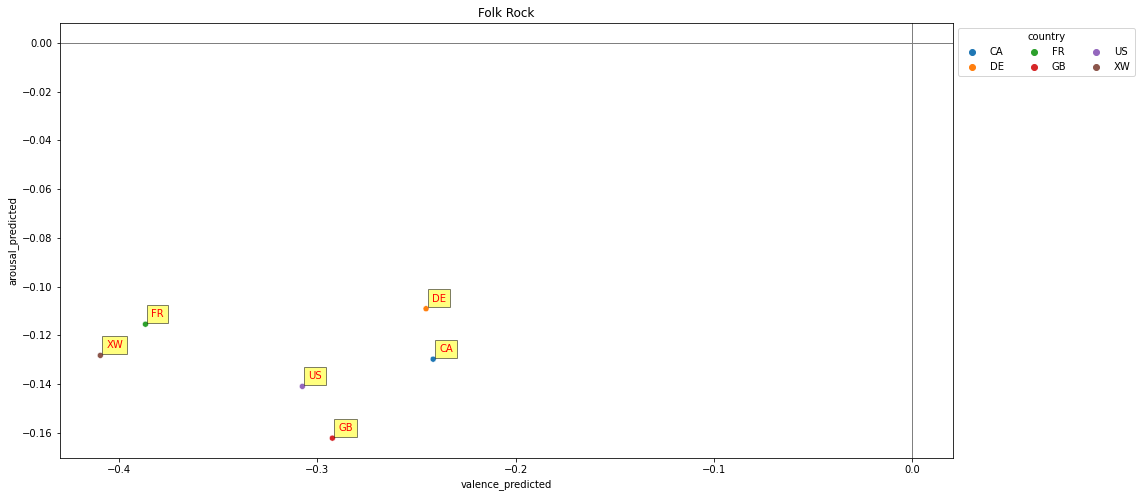

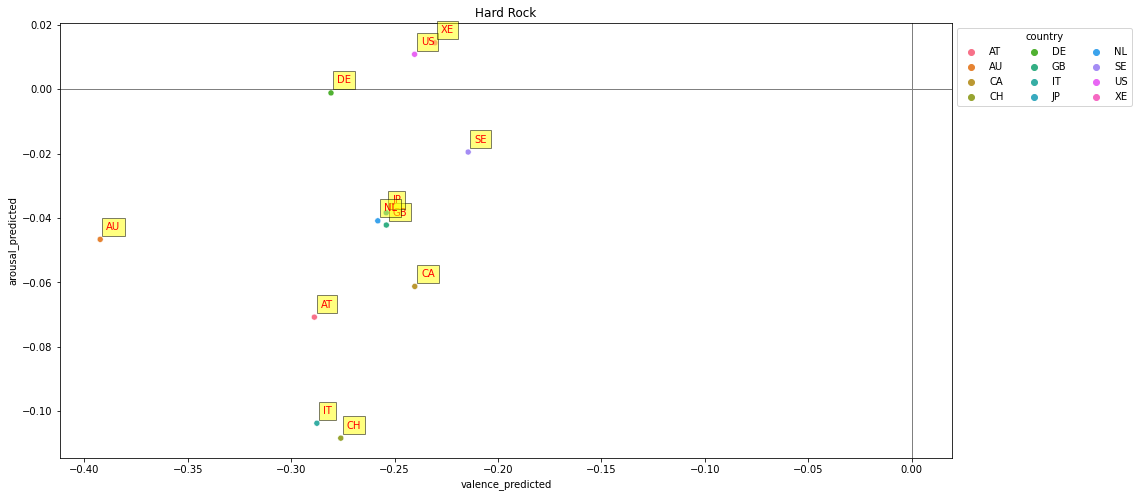

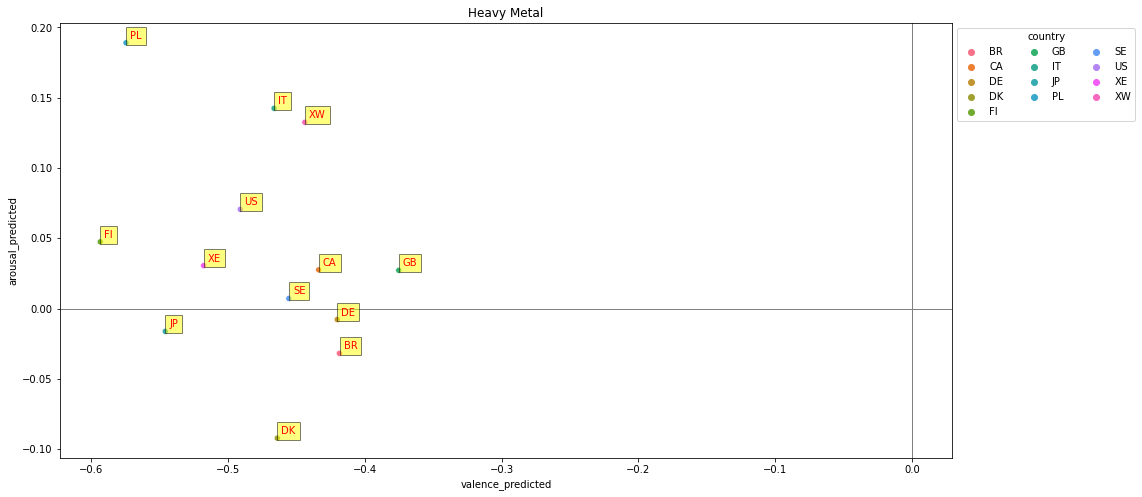

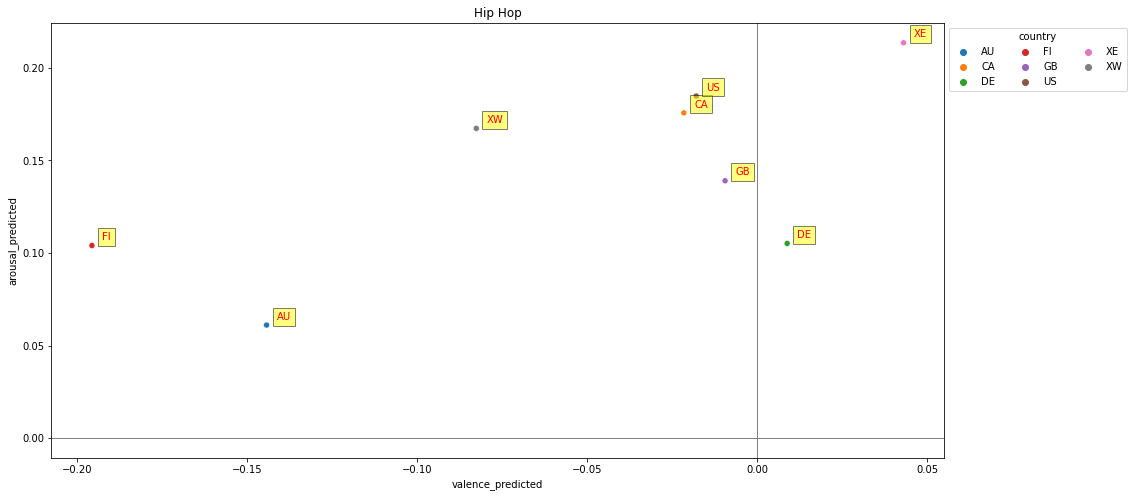

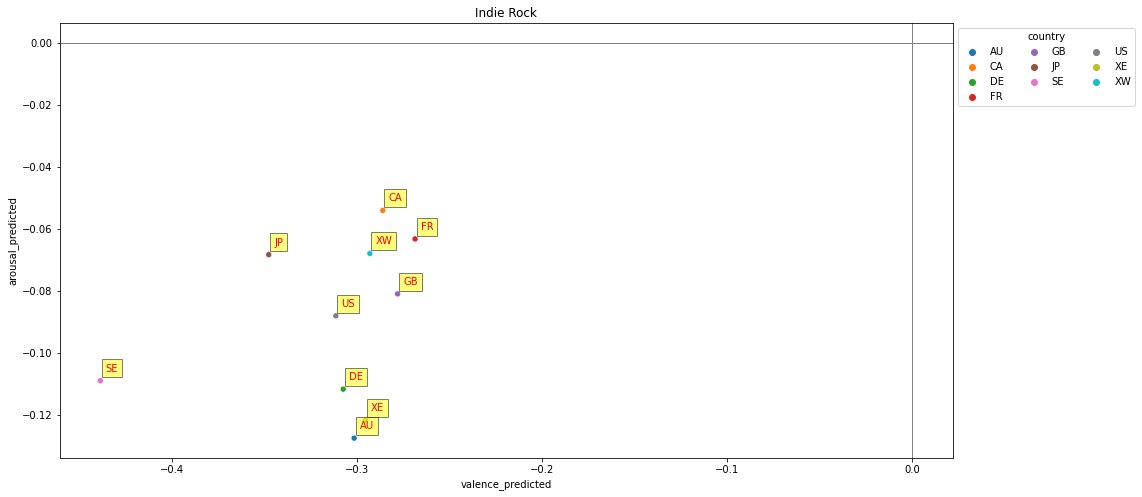

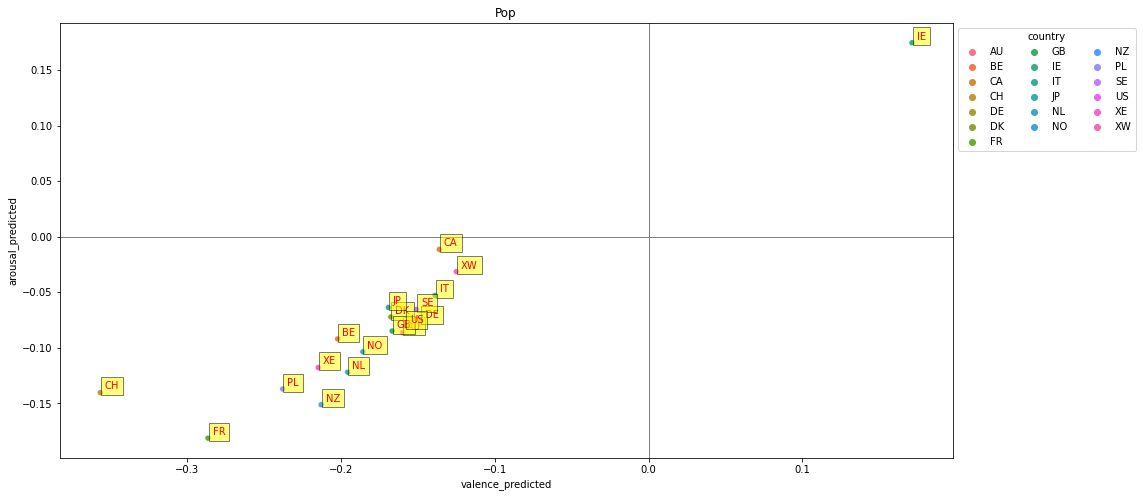

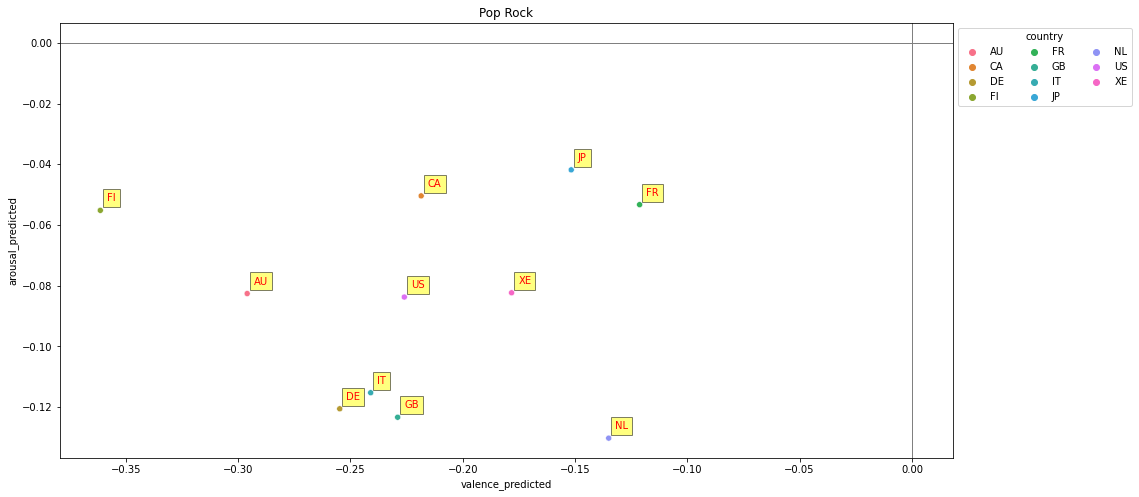

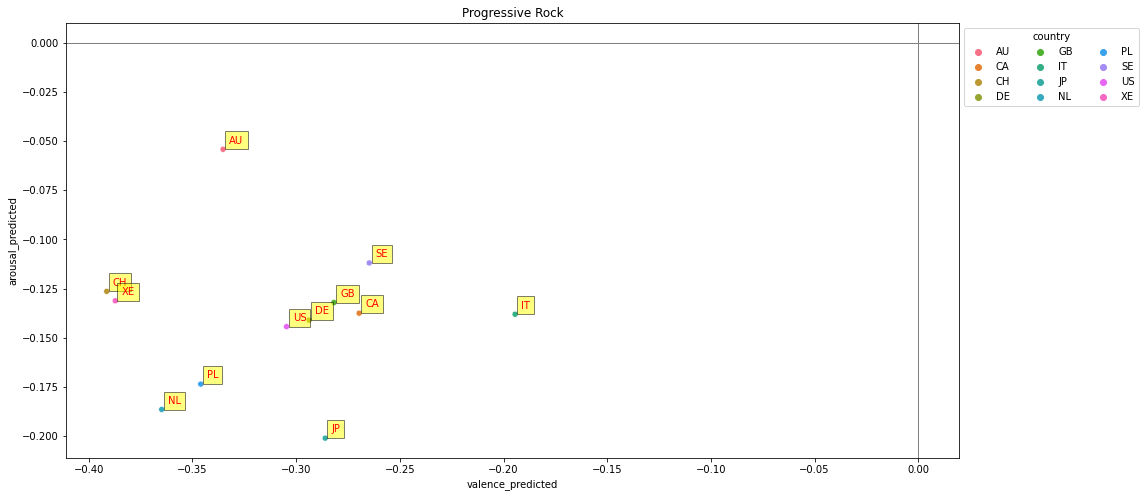

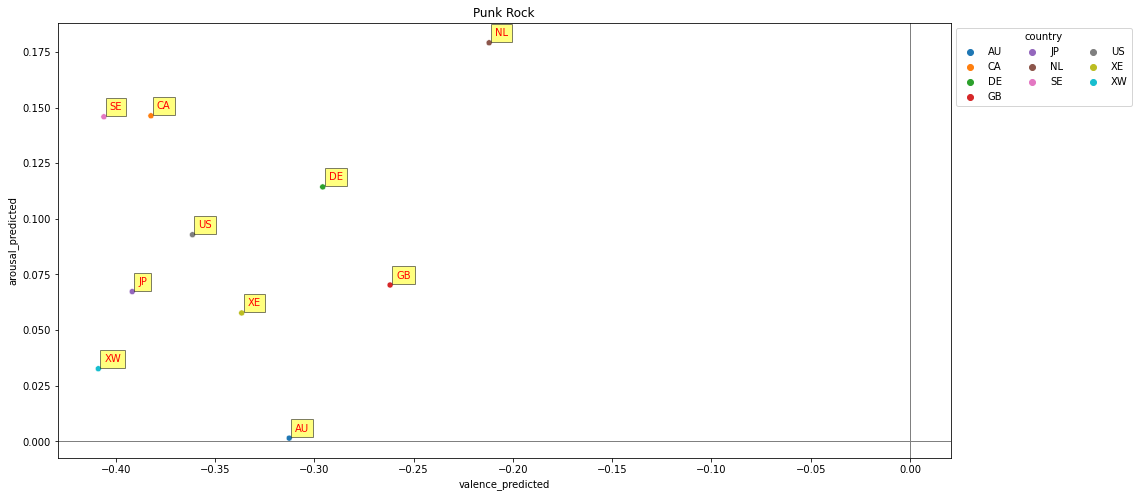

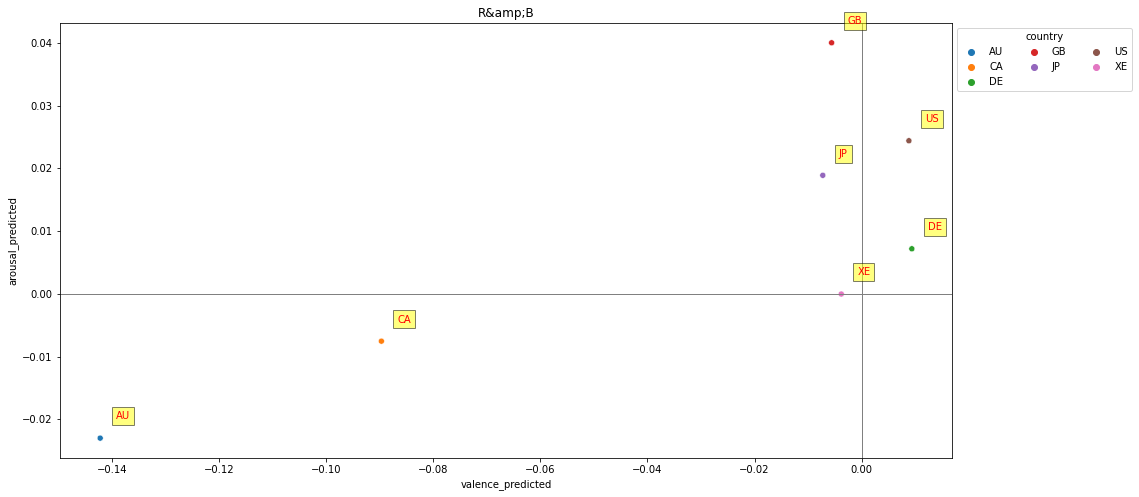

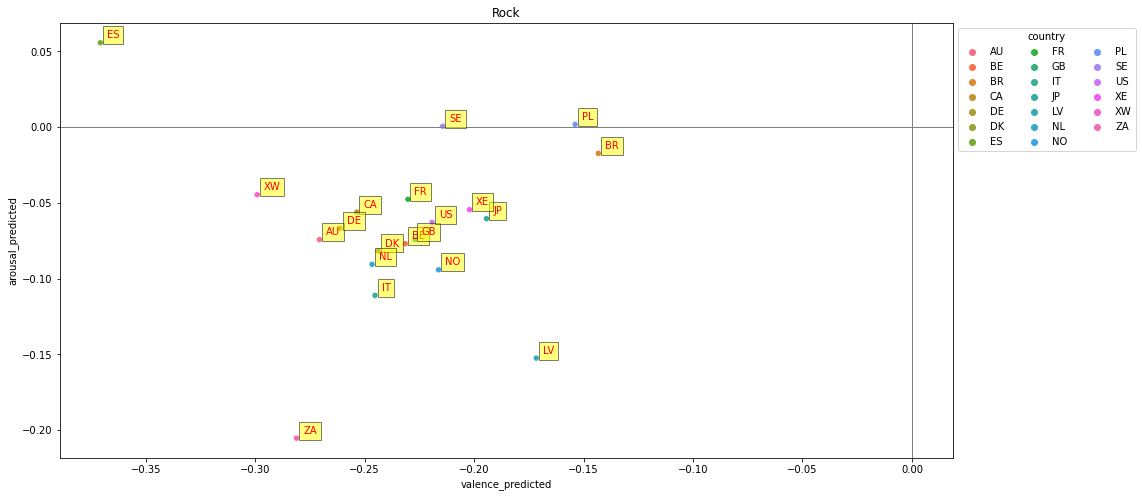

In [36]:
for genre, gp in lyric_english.groupby('album_genre'):
    # only consider the genres that have more than 10000 songs
    if len(gp.index) > 10000:
        emotion_distribution(gp, 'country', 50, genre)

In [58]:
lyric_english[lyric_english['country']=='FI']['album_genre'].value_counts()

Power Metal            239
Alternative Rock       184
Heavy Metal            181
Black Metal            170
Melodic Death Metal    141
Gothic Metal           119
Doom Metal             107
Hip Hop                 76
Progressive Metal       76
Folk Metal              75
Symphonic Metal         58
Death Metal             57
Pop Rock                57
Thrash Metal            51
Industrial Metal        42
Hard Rock               34
Punk Rock               33
Post-Rock               33
Rock                    32
Industrial              27
Electronic              26
Pop                     25
Riot Grrrl              24
Progressive Rock        20
Breakbeat               10
Gothic Rock             10
Trance                  10
Viking Metal             8
Christmas                4
Folk                     3
Disco                    2
Indie Pop                2
Reggae                   1
Dancehall                1
R&amp;B                  1
Humppa                   1
Name: album_genre, dtype: in

Another possibility is to compute average emotion scores for each genre, then to compute genre-based predictions for each country (e.g. if 60% of the Finland songs were metal and 40% were soft rock, the "genre-based" prediction for Finland would be 0.6 * [average metal score] + 0.4 * [average soft rock score]. You can then see whether the actual Finland emotion score is different from the genre-based prediction for Finland.

In [86]:
genre_based_valence = defaultdict(float)
lyric_english_major = filtering(lyric_english, 500, 'country')
genre_valence = lyric_english_major.groupby('album_genre')['valence_predicted'].mean()

for country, country_gp in lyric_english_major.groupby('country'):
    genre_dict = country_gp['album_genre'].value_counts()
    for genre, genre_gp in country_gp.groupby('album_genre'):
        weight = genre_dict[genre] / genre_dict.sum()
        genre_based_valence[country] += genre_valence[genre] * weight

In [87]:
valence_comparison = pd.DataFrame({'original': emotion_mean_english['valence_predicted'],
                                   'genre_based': genre_based_valence})

valence_comparison.index.name = 'country'
valence_comparison.reset_index(inplace=True)
valence_comparison_melt = pd.melt(valence_comparison, id_vars="country", var_name="type", value_name="valence")

<AxesSubplot:xlabel='country', ylabel='valence'>

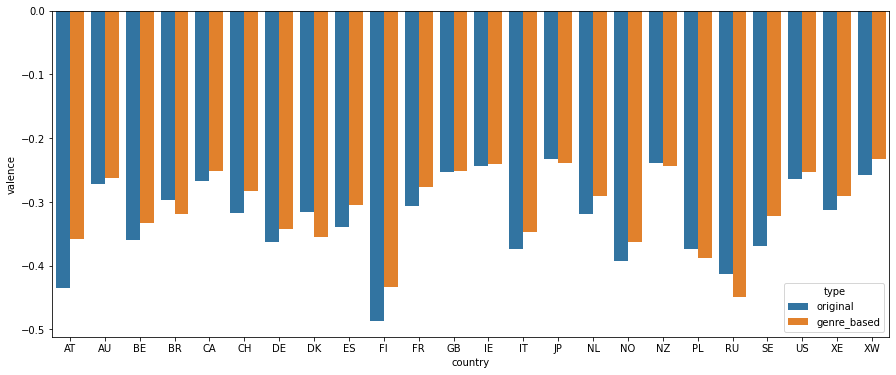

In [88]:
plt.figure(figsize=(15,6))
sns.barplot(data=valence_comparison_melt, x="country", y="valence", hue="type")

In [79]:
valence_comparison

country  original  genre_based
0       AT -0.434258    -0.386331
1       AU -0.271150    -0.278008
2       BE -0.360276    -0.365135
3       BR -0.296512    -0.284638
4       CA -0.267492    -0.262365
5       CH -0.316653    -0.296924
6       DE -0.363131    -0.342713
7       DK -0.315584    -0.334996
8       ES -0.339405    -0.289519
9       FI -0.487130    -0.458423
10      FR -0.306454    -0.271646
11      GB -0.252629    -0.244203
12      IE -0.243955    -0.198743
13      IT -0.373757    -0.356710
14      JP -0.232083    -0.244096
15      NL -0.319121    -0.287858
16      NO -0.392893    -0.368306
17      NZ -0.238527    -0.222465
18      PL -0.374195    -0.333132
19      RU -0.412690    -0.442059
20      SE -0.368959    -0.352290
21      US -0.263447    -0.252341
22      XE -0.312932    -0.300812
23      XW -0.257924    -0.246831

# Regression Model

In [54]:
lyric_english_major

Unnamed: 0                                 _id abstract_x  \
0                 0  ObjectId(5714dec325ac0d8aee3804e7)        NaN   
1                 1  ObjectId(5714dec325ac0d8aee3804e8)        NaN   
2                 2  ObjectId(5714dec325ac0d8aee3804e9)        NaN   
3                 3  ObjectId(5714dec325ac0d8aee3804ea)        NaN   
4                 4  ObjectId(5714dec325ac0d8aee3804eb)        NaN   
...             ...                                 ...        ...   
2099274     2099274  ObjectId(57c92594e5c453a411c7732e)        NaN   
2099275     2099275  ObjectId(57c92594e5c453a411c7732f)        NaN   
2099276     2099276  ObjectId(57c92594e5c453a411c77330)        NaN   
2099277     2099277  ObjectId(57c92594e5c453a411c77331)        NaN   
2099278     2099278  ObjectId(57c92594e5c453a411c77332)        NaN   

                    albumTitle       album_genre animux_content  \
0        How Ace Are Buildings  Alternative Rock            NaN   
1        How Ace Are Buildings  Alternative Rock            NaN   
2        How Ace Are Buildings  Alternative Rock            NaN   
3        How Ace Are Buildings  Alternative Rock            NaN   
4        How Ace Are Buildings  Alternative Rock            NaN   
...                        ...               ...            ...   
2099274  5 (Murder By Numbers)           Hip Hop            NaN   
2099275  5 (Murder By Numbers)           Hip Hop            NaN   
2099276  5 (Murder By Numbers)           Hip Hop            NaN   
2099277  5 (Murder By Numbers)           Hip Hop            NaN   
2099278  5 (Murder By Numbers)           Hip Hop            NaN   

        animux_contents animux_path_x animux_paths  arousal  ...  \
0                   NaN           NaN           []      NaN  ...   
1                   NaN           NaN           []      NaN  ...   
2                   NaN           NaN           []      NaN  ...   
3                   NaN           NaN           []      NaN  ...   
4                   NaN           NaN           []      NaN  ...   
...                 ...           ...          ...      ...  ...   
2099274             NaN           NaN           []      NaN  ...   
2099275             NaN           NaN           []      NaN  ...   
2099276             NaN           NaN           []      NaN  ...   
2099277             NaN           NaN           []      NaN  ...   
2099278             NaN           NaN           []      NaN  ...   

         members.XX.urlYouTube members.XX.urlBBC  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   
...                        ...               ...   
2099274                    NaN               NaN   
2099275                    NaN               NaN   
2099276                    NaN               NaN   
2099277                    NaN               NaN   
2099278                    NaN               NaN   

        members.XX.urlSecondHandSongs urlInstagram members.XX.urlSoundCloud  \
0                                 NaN          NaN                      NaN   
1                                 NaN          NaN                      NaN   
2                                 NaN          NaN                      NaN   
3                                 NaN          NaN                      NaN   
4                                 NaN          NaN                      NaN   
...                               ...          ...                      ...   
2099274                           NaN          NaN                      NaN   
2099275                           NaN          NaN                      NaN   
2099276                           NaN          NaN                      NaN   
2099277                           NaN          NaN                      NaN   
2099278                           NaN          NaN  

In [53]:
lyric_english_major = filtering(lyric_english, 500, 'country') # only keep countries that has more than 500 songs.
lyric_english_major = filtering(lyric_english_major, 5000, 'album_genre') # only keep albums that has more than 5000 songs.
lyric_english_major.to_csv('dataset/lyric_english_major.csv')

In [ ]:
# Load your data
data = pd.read_csv("your_data.csv")

# Fit the regression model with lmer
model = lmer('valence ~ (1|country) + (1|genre)', data=data)

# Get the estimated coefficients for country and genre
country_coef, genre_coef = model.coef['group'].values()

# Plot the coefficients
fig, ax = plt.subplots()
ax.bar(['Country', 'Genre'], [country_coef, genre_coef])
ax.set_xlabel('Random Effect')
ax.set_ylabel('Coefficient')
plt.show()